# Laboratorio 2: CompuAlpes

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 202012723
- David Gonzales - 201815834

CompuAlpes es una reconocida tienda minorista que vende computadores portátiles de diferentes fabricantes y especificaciones técnicas. Con el auge de la tecnología y el creciente número de productos en el mercado, la empresa busca optimizar sus estrategias de fijación de precios y promociones para seguir siendo competitiva. Es en este último punto, donde ha identificado un reto relacionado con **determinar el precio adecuado para un portatil** ya que el mercado es dinámico y la valoración de las características técnicas cambia con el tiempo. Poner un precio demasiado alto puede alejar a los clientes, mientras que ponerlo demasiado bajo puede reducir los márgenes de ganancia.

Esto motivó a CompuAlpes a proponer el objetivo de este proyecto, en el cual se desea **construir un modelo de regresión que permita estimar el precio de un portátil a partir de sus especificaciones técnicas, determinando las que más impactan en el precio o que son, de acuerdo a la evidencia, irrelevantes para la estimación**. Este modelo permitirá a CompuAlpes tener una base objetiva y cuantitativa al momento de establecer precios para sus productos.

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

### Carga de los datos

In [2]:
df = pd.read_csv('./data/202320_Laboratorio 2 - Regresión_data_laptop_data_train.csv')

## 1. Entendimiento de los datos

En esta etapa es importante saber si los datos son o no suficientes para el alcance del proyecto y, en caso de serlo, entender bien sus características para poder definir el camino de limpieza y preparación para lograr el objetivo del proyecto.

En particular, es importante realizar un perfilamiento donde se incluye estadística descriptiva y gráficos sobre los datos, señalando sus principales estadísticos. Debido a que el objetivo es crear un modelo de regresión solo haremos uso de las variables númericas. Hay que tener en cuenta que el objetivo fundamental de esta etapa está relacionada con el análisis a nivel de calidad de datos y, en particular, a nivel de las dimensiones de calidad (completitud, unicidad, consistencia, validez) para identificar las actividades de preparación que requieren los datos.

### 1.1 Perfilamiento de datos

In [3]:
df.shape

(1216, 14)

In [4]:
df.dtypes

id               int64
Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

In [5]:
df.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
142,965,Dell,Notebook,4,2.25,302.137406,0,0,100.454670,Intel Core i3,1000.0,0,AMD,Others
705,816,Razer,Ultrabook,16,1.29,11.470547,1,1,352.465147,Intel Core i7,0.0,512,Intel,Windows
1199,381,Lenovo,Notebook,4,1.85,9.975738,0,0,141.211998,Intel Core i3,0.0,128,Intel,Others
660,688,HP,Notebook,6,2.65,10.319441,0,1,127.335675,AMD Processor,2000.0,0,AMD,Windows
1011,250,Dell,2 in 1 Convertible,8,2.08,10.683645,1,1,141.211998,Intel Core i7,1000.0,0,Intel,Windows


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


In [57]:
df.describe()

,id,Ram,Weight,Price,TouchScreen,Ips,Ppi,HDD,SSD
count,1216.000000,1216.000000,1193.000000,1201.000000,1216.000000,1216.000000,1204.000000,1200.000000,1216.000000
mean,637.925164,8.458882,2.401572,13.114402,0.145559,0.285362,183.830716,441.218800,187.529605
std,367.482876,5.094332,4.844791,28.659102,0.352809,0.451772,449.708876,927.052855,186.902926
min,0.000000,2.000000,0.690000,9.134616,0.000000,0.000000,90.583402,0.000000,0.000000
25%,319.750000,4.000000,1.500000,10.403650,0.000000,0.000000,127.335675,0.000000,0.000000
50%,638.500000,8.000000,2.040000,10.882316,0.000000,0.000000,141.211998,0.000000,256.000000
75%,954.250000,8.000000,2.320000,11.288115,0.000000,1.000000,157.350512,1000.000000,256.000000
max,1272.000000,64.000000,97.729949,499.766079,1.000000,1.000000,7328.468865,24127.543112,1024.000000


### Análisis de variables categoricas

A continluación análisaremos las variables categoricas con el fin de encontrar si es necesario usarlas en nuestro modelo de regresion. Si se llega a escoger alguna variables categorica se tendra que usar una técnica como Label Encoding o One Hot Encoding para pasar los valores categoricos a númericos ya que el modelo solo recibe este tipo de datos.

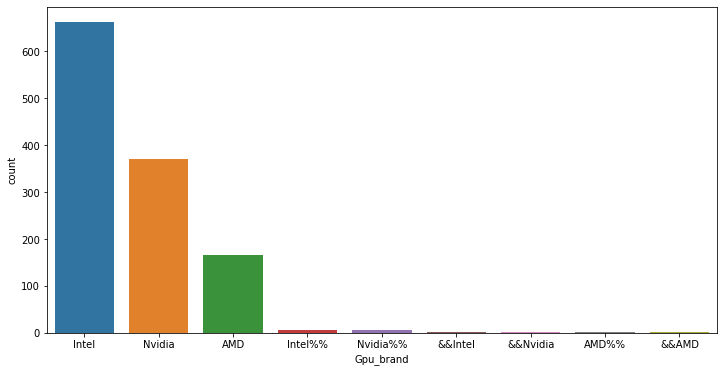

In [62]:
plt.figure(figsize=(12, 6))
sns.countplot(x='Gpu_brand', data=df)
plt.show()

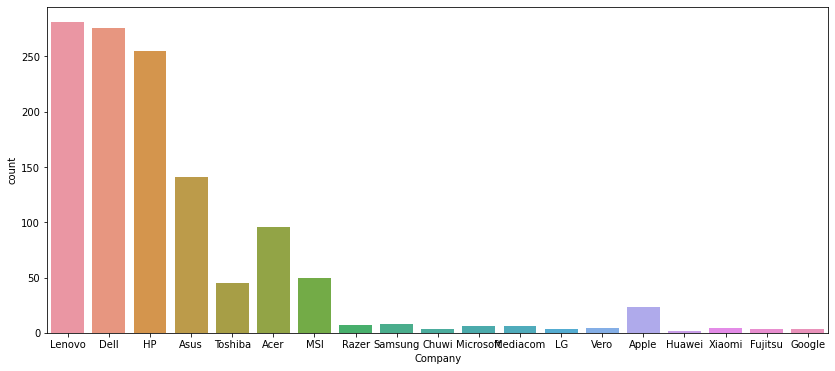

In [60]:
plt.figure(figsize=(14, 6))
sns.countplot(x='Company', data=df)
plt.show()

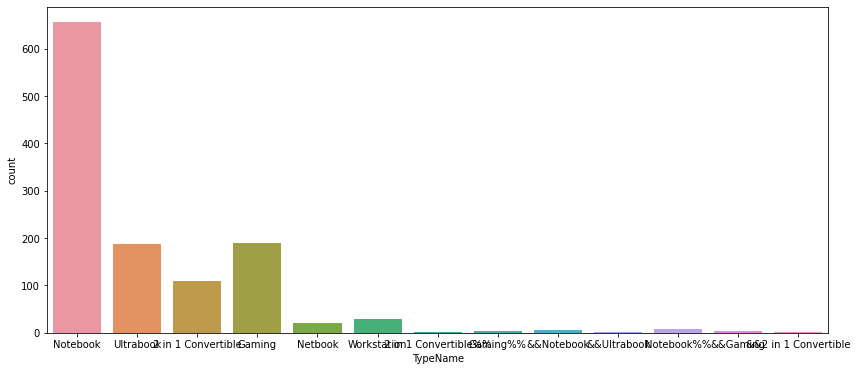

In [61]:
plt.figure(figsize=(14, 6))
sns.countplot(x='TypeName', data=df)
plt.show()

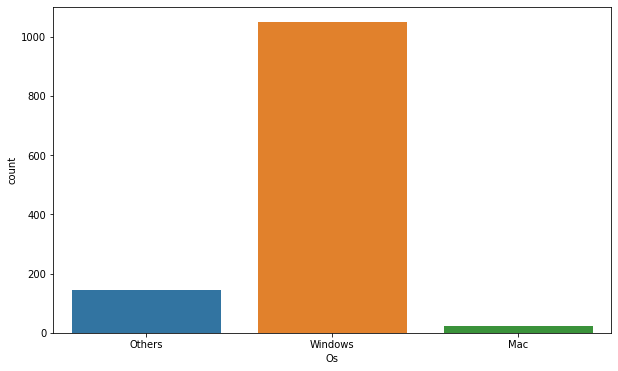

In [65]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Os', data=df)
plt.show()

Anteriormente se mostraron gráficas para las 4 variables categoricas presentes `Company`, `TypeName`, `Os` y `Gpu_brand`. Todas a excepción de `Os` presentan errores de consistencia ya que hay nombres que son iguales pero con errores de tipografia.

Al realizar un análisis detallado sobre estas 4 variables, como equipo consultor tomamos la decisión de no usarlas para el modelo. El principal motivo es que no aportan a la estimación de la variable objetvio `Price`. La mejor forma de entender el por qué el impacto es tan bajo sería la siguiente. Supongamos que los precios solo tienen tres categorias, bajo, medio y alto. Teniendo en cuenta lo anterior si examinamos `Company` veremos que casi todas las compañias presentan computadores con los tres rangos de precios. Lo mismo pasa si solo vemos el `TypeName`, `Os` y `Gpu_bran`, esto no ayuda a la estimación del target y esto fue lo que nos llevo a la decisión de no tomarlas en cuenta. 

### Análisis de variables númericas

In [87]:
vars_numericas = ['Ram', 'Weight', 'Price', 'Ppi', 'HDD', 'SSD']

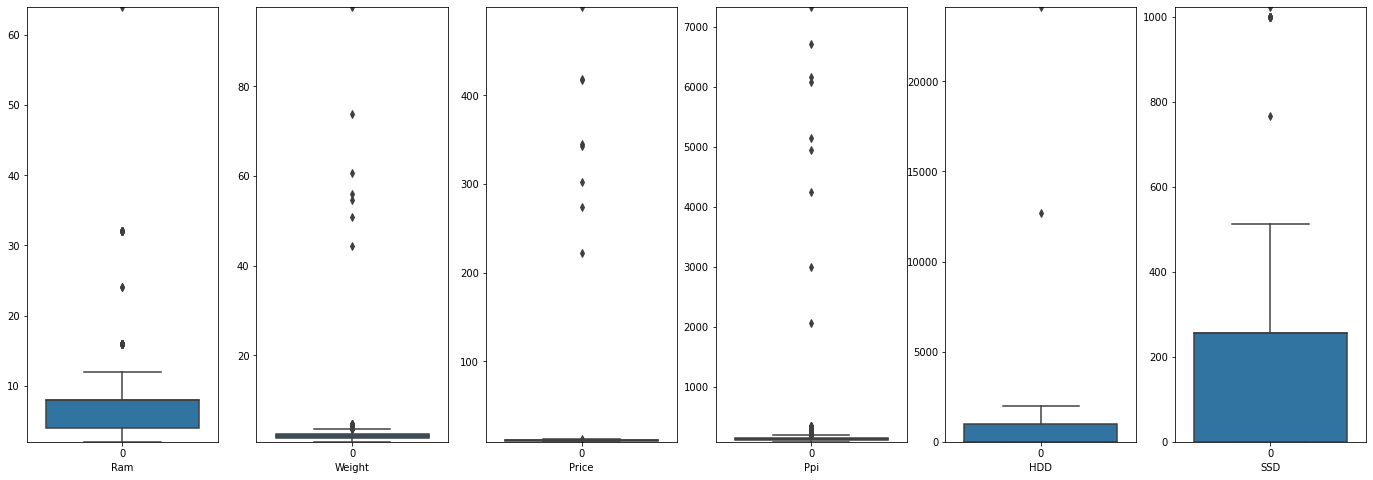

In [91]:
fig, axes = plt.subplots(ncols=len(vars_numericas), figsize=(24,8))
for i, col in enumerate(vars_numericas):
    ax = sns.boxplot(data=df[col], ax=axes[i])
    ax.set_ylim(df[col].min(), df[col].max())
    axes[i].set_xlabel(vars_numericas[i])
plt.show()

<AxesSubplot:>

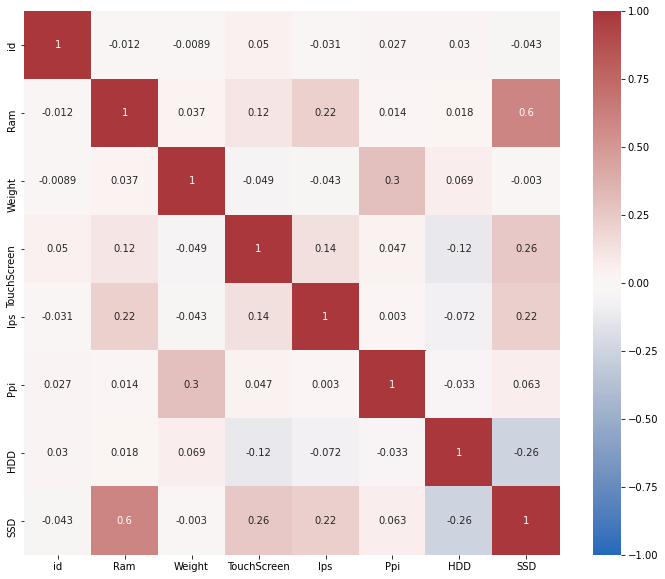

In [94]:
plt.figure(figsize = (12, 10))
sns.heatmap(df.drop(['Price'], axis=1).corr(), annot=True, cmap = 'vlag', vmin = -1, vmax = 1)

Por una lado tenemos un boxplot ajustado con los diferentes ejes en y de las diferentes variables númericas (se exceptuaron `Ips` y `TouchScreen` ya que son binarias). Esto nos permite inspeccionar con más detalle valores atipicos y outliers. Podemos observar ver que todas las variables númericas presentan outliers, aunque algunas presentan outliers más preocupantes que otros. Este es el caso de `Price`, `Weight` y `Ppi`, ya que en estas los outliers son valores tan altos que ni siquiera se aprecia la diferencia entre los valores de los quartiles bajos y altos.

Por otra parte exploramos las variantes númericas (exceptuando `Price` ya que esta es el target) haciendo uso de un heatmap, esto con el motivo de ver la correlación entre las variables y cerciorarnos de que no halla una fuerte correlación entre alguna de ellas. Al revisar con detalle confirmamos que no hay ninguna correlación mayor a 0.8 (de ser así esta variable se tendría que eliminar ya que [alta correlación afecta el modelo](https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e) ) 

### 1.2 Seleccion de features 

Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Para el primer modelo que vamos a construir nuestras features seran todas las variables númericas con las que contamos a excepción de `id` debido a que esta no aporta para la construcción del modelo. Consideramos que cada una de estas son importantes para la estimación de la variable objetivo (target) `Price`.

Adicionalmente, como equipo análizamos y concluimios que no le aporta mucho al modelo planeado realizar una conversión de variables categoricas a númericas para `Company`, `TypeName`, `OS` y `Gpu_brand` (esta decisión se analizó con más detalle en la sección 1.1). Por otro lado estan las varibales `Ips` y `TouchScreen`, estas en realidad son categoricas pero en el dataset que se nos da ya vienen transforamdas a númericas con valores de 0 o 1. El motivo por el cual se decidió incluir estas dos variables dentro de las features a pesar de ser booleanas es que consideramos que ambas influyen directamente en el precio de un computador.

In [7]:
features = ['Ram', 'Weight', 'SSD','TouchScreen','Ips','HDD','Ppi']

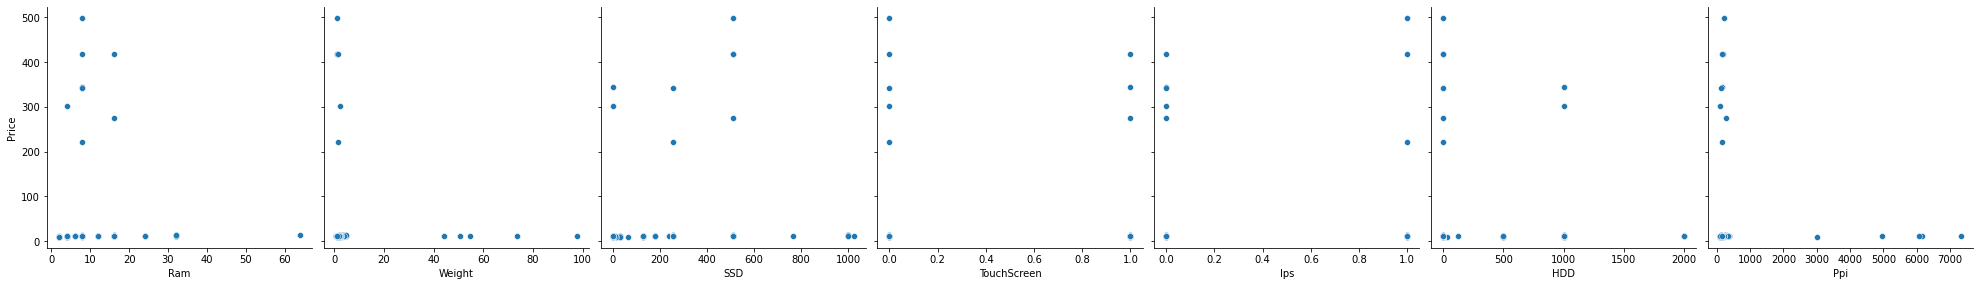

In [16]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features, kind = 'scatter')

### 1.3 Análisis de calidad de datos

Este análisis se hara solo con las features y la variable objetivo ya que estas son las que nos interesan para construir el modelo. Las demás variables no se tendran en cuenta.

### 1.3.1 Completitud

In [9]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price          0.012336
Ram            0.000000
Weight         0.018914
SSD            0.000000
TouchScreen    0.000000
Ips            0.000000
HDD            0.013158
Ppi            0.009868
dtype: float64

Los datos con los que trabajaremos presentan bajo procentaje de valores nulos, lo cual implica buen grado de completitud

### 1.3.2 Unicidad

In [10]:
df.loc[df.duplicated(subset=features, keep=False)].sort_values(by=features).head(6)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
546,1126,Lenovo,2 in 1 Convertible,4,0.690,10.147262,1,1,224.173809,Other Intel Processor,0.0,0,Intel,Windows
930,1082,Lenovo,&&2 in 1 Convertible,4,0.690,10.446778,1,1,224.173809,Other Intel Processor,0.0,0,Intel,Windows
181,959,Acer,2 in 1 Convertible,4,1.250,9.939140,1,1,135.094211,Other Intel Processor,0.0,0,Intel,Others
1016,619,Acer,2 in 1 Convertible,4,1.250,9.913097,1,1,135.094211,Other Intel Processor,0.0,0,Intel,Others
373,457,Microsoft,Ultrabook,4,1.252,10.872255,1,0,200.842560,Other Intel Processor,0.0,128,Intel,Windows
502,70,Microsoft,Ultrabook,4,1.252,10.968576,1,0,200.842560,Intel Core i5,0.0,128,Intel,Windows


In [11]:
duplicated_rows = df.loc[df.duplicated(subset = features, keep = False)].shape[0]
duplicated_rows

542

In [95]:
print('Duplicates %:', (duplicated_rows / df.shape[0])*100)

Duplicates %: 44.57236842105263


In [13]:
df.loc[df.duplicated(subset = features+['Price'], keep = False)].sort_values(by=features).head(6)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
128,645,Lenovo,Notebook,4,1.43,9.588689,0,0,111.935204,Other Intel Processor,0.0,0,Intel,Windows
1096,645,Lenovo,Notebook,4,1.43,9.588689,0,0,111.935204,Other Intel Processor,0.0,0,Intel,Windows
395,212,HP,Notebook,4,2.10,9.830633,0,0,141.211998,Intel Core i3,500.0,0,Intel,Others
999,101,HP,Notebook,4,2.10,9.830633,0,0,141.211998,AMD Processor,500.0,0,AMD,Windows
422,884,Dell,&&Notebook,4,2.20,9.886358,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows
622,1172,Asus,Notebook,4,2.20,9.886358,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows


In [97]:
duplicated_rows = df.loc[df.duplicated(subset = features + ['Price'], keep = False)].shape[0]
duplicated_rows

20

In [98]:
print('Duplicates %:', (duplicated_rows / df.shape[0])*100)

Duplicates %: 1.644736842105263


Aquí hay dos escenarios a analizar:

1. Existe un 44.6% de registros con variables de entrada duplicadas, incluso con variable objetivo diferente. Una cantidad un poco preocupante, por lo cual requeriría de un proceso complementario de limpieza de datos para evitar confundir al modelo al momento de aprender la función de estimación.

2. Al incluir la variable objetivo dentro del análisis de duplicados, se obtiene el 1.6% registros duplicados adicionales. Para un porcentaje mayor esto representaría potencialmente otro problema obligando al algoritmo de optimización a enfocarse más en aquellos registros duplicados en lugar de ponderar todos los registros por igual.

Evaluendo la situación con mayor detalle, la mejor opción es limpiar estos duplicados en la fase de preparación, otra opción podría ser agregar más features pero el problema es que estamos usando todas la features númericas posibles. Para agregar más features se podrían pasar las 4 categoricas que anteriormente excluimos pero al revisar con mayor detalle, esto no ayudaría de mucho, ya que al revisar las tuplas que estan repetidas vemos que en la mayoría tambien se repiten los datos categoricos. Esto podría ser porque se tienen el mismo computador con las mismas especificaciones varias veces.

### 1.3.3 Consistencia

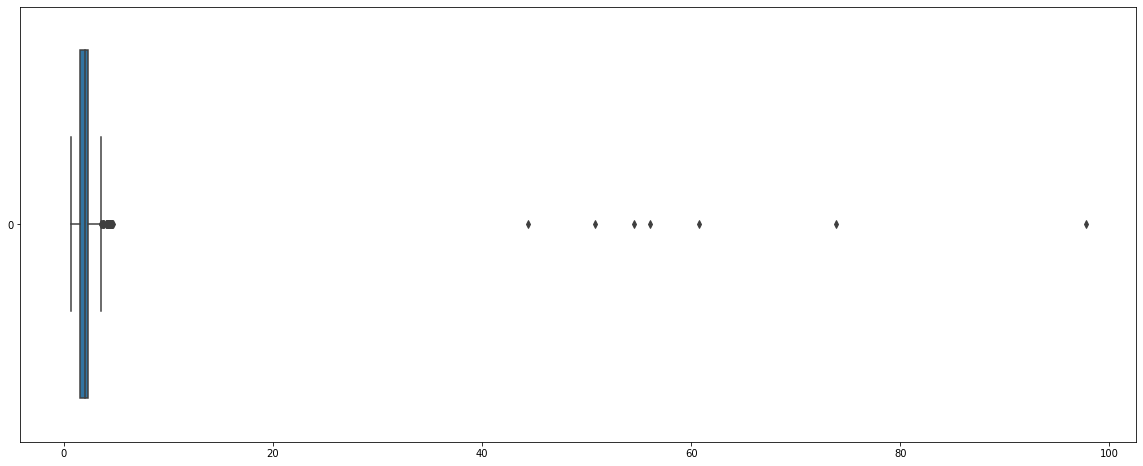

In [101]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df.Weight, orient="h")

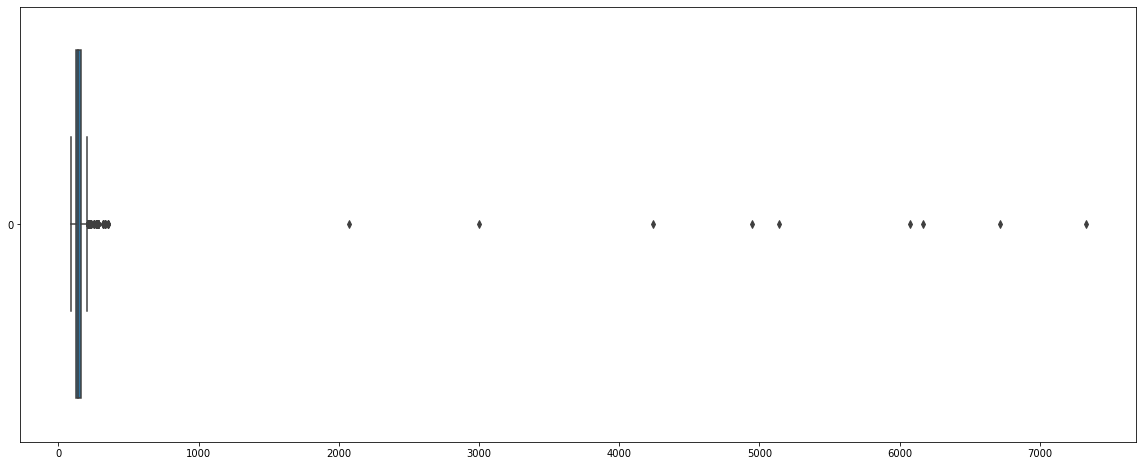

In [102]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df.Ppi, orient="h")

Al revisar con detalle los atributos `Weight` y `Ppi` encontramos inconsistencias:

- `Weight`: en el diccinario que se no dio se explica que este atributo describe el peso del computador en kg. Al ver la gráfica de peso vemos que los outliers son computadores que pesan más de 40 kg lo cual no es posible

- `Ppi`: este atributo representa los pixeles por pulgada del computador. Vemos que los outliers son valores mayores a 2000 ppi, por lo tanto investigamos y nos dimos cuenta de que para un computador es muy díficl tener una cantidad mayor a 2000 ppi. Por esto somos muy escepticos de estos valores y consideramos que estos probablemente son errores debido a que se salen por mucho de [la media de los computadores](https://artegence.com/blog/ppi-the-final-unknown-parameter-of-a-devices-screen-quality/#:~:text=For%20modern%20laptops%3A%20~%20130%20PPI,%2F%20~%2080%20PPI%20(4K))

### 1.3.4 Validez

Al examinar los datos proporcionados por la empresa vemos que estos son muy validos aunque hay varias cosas por mejorar. Hay que tener cuidado con los outliers y hay que corregir los erroresm mencionados anteriormente de consistencia y unicidad. Todo esto se hara en la fase de preparación de datos buscando tener todo listo para arrancar con la creación del modelo

## 2. Preparación de datos

In [103]:
df.shape

(1216, 14)

In [104]:
df = df.dropna(subset = ['Price'] + features)

In [105]:
df.shape

(1170, 14)

In [106]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price          0.0
Ram            0.0
Weight         0.0
SSD            0.0
TouchScreen    0.0
Ips            0.0
HDD            0.0
Ppi            0.0
dtype: float64

In [107]:
df.drop_duplicates(subset=features, inplace=True)
df.drop_duplicates(subset=features+["Price"], inplace=True)

c:\Users\juank\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [108]:
duplicated_rows = df.loc[df.duplicated(subset = features, keep = False)].shape[0]
duplicated_rows

0

## 3. Modelado

### 3.1 Particionamiento del conjunto de datos en entrenamiento y prueba

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.3, random_state=1)

In [110]:
X_train.shape, y_train.shape

((569, 7), (569,))

In [111]:
X_test.shape, y_test.shape  

((244, 7), (244,))

### 3.2 Entrenamiento de un primer modelo de regresión lineal

In [112]:
regression= LinearRegression()  

In [113]:
regression.fit(X_train, y_train)

LinearRegression()

### 3.3 Interpretación de los coeficientes y del intercepto

Antes de entrar en detalles con el análisis, vale la pena recordar la forma en la que esta dado el modelo de regresión lineal:

$$ y = {\beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \beta_{3}x_{3} + \beta_{4}x_{4} + \beta_{5}x_{5}} $$

siendo $\beta_{0}$ el intercepto (bias) y $\beta_{1}$, $\beta_{2}$, $\beta_{3}$, $\beta_{4}$ y $\beta_{5}$ los coeficientes o parámetros correspondientes a las variables de entrada en el mismo orden.

In [114]:
pd.DataFrame({'features': features, 'coef': regression.coef_})  

,features,coef
0,Ram,0.039478
1,Weight,-0.017352
2,SSD,0.001269
3,TouchScreen,-0.708663
4,Ips,1.313501
5,HDD,-0.000523
6,Ppi,0.000062


Revisar los coeficientes brindan una intuición del impacto o la fuerza de una variable de entrada en la estimación de la variable objetivo. En este caso vemos que `TouchScreen` y `Ips` resaltan sobre el resto de variables significativamente. Esto puede ser debido a que ambas tienen gran impacto a la hora de decidir el precio de un producto. Otra hipotesis es que ambos son los únicos que son binarios, esto implica que no tienen outliers,mientras que el resto de variables tiene outliers lo cual podría estar afectando el modelo

In [115]:
regression.intercept_

10.610608267227532

En este caso no tiene sentido [interpretar el intercepto](https://www.statology.org/intercept-in-regression/)  $\beta_{0}$ ya que este representa la respuesta cuando todas las variables de predición en el modelo son igual a 0. En nuestro caso no tiene mucho sentido ya que si suponemos que un computador tiene 0 en Ram, HHD o SSD, Ppi y en el resto de variables su precio no podría ser de 10.6k rupias. De todos modos, por más que no tenga sentido interpretarlo, este es crucial para realizar las predicciones de la variable objetivo

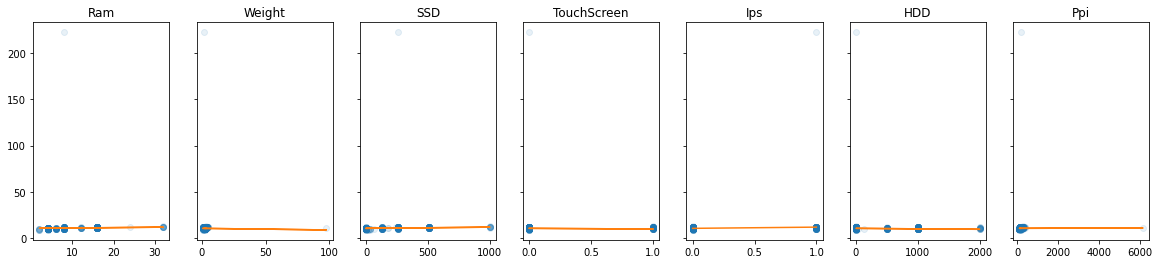

In [116]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Cabe aclarar que por más de que `TouchScreen` y `Ips` aparentemente tengan mayor impacto sobre la estimación de la variable objetivo, esto no es 100% seguro. Esto se debe a que las variables de entrada no se encuentran en la misma escala, rangos o grados de magnitud. Debido a esto, las magnitudes o valores de los coeficientes no son directamente comparables entre sí, es decir, no es posible afirmar que `TouchScreen` tiene mayor impacto que `Ram` o `Weight` sobre la variable objetivo. Aunque si se podría afirmar que `Weight` tiene un impacto negativo en la estimación   

## 4. Evaluación cuantitativa


**Mean Absolute Error (MAE)**

In [117]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 1.055848556033859
Test: 4.375334905787383


**Root Mean Squeared Error (RMSE)**

In [118]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 8.83263273220091
Test: 40.58846061400504


**Análisis del error**

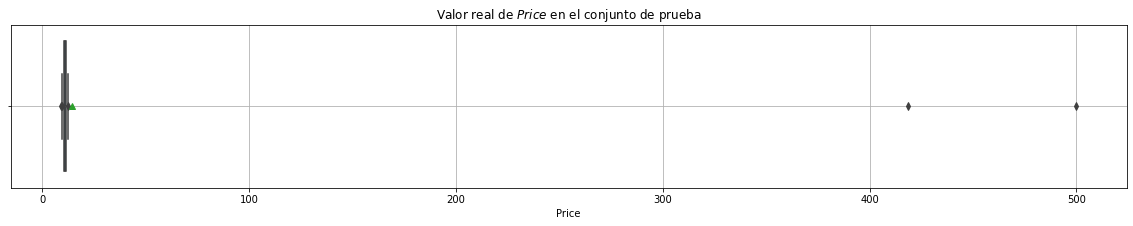

In [119]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Price}$ en el conjunto de prueba")
plt.grid()
plt.show()

## 5. Evaluación cualitativa

In [36]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    351.000000
mean      13.341128
std       33.934355
min        9.134616
25%       10.328152
50%       10.841452
75%       11.234697
99%       12.312879
max      499.766079
Name: Price, dtype: float64

## 6. Entrenamiento de un segundo modelo retirando outliner

In [37]:
df.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
549,456,Dell,Notebook,8,4.42,11.599203,0,1,127.335675,Intel Core i7,1000.0,0,Nvidia,Windows
381,727,Dell,2 in 1 Convertible,4,1.71,10.450994,1,0,165.632118,Intel Core i3,1000.0,0,Intel,Windows
1136,184,Xiaomi,Notebook,8,1.95,11.064804,0,1,141.211998,Intel Core i5,0.0,256,Nvidia,Others
216,1148,HP,Notebook,8,1.88,11.340108,0,0,141.211998,Intel Core i5,0.0,256,Intel,Windows
677,379,Acer,Notebook,8,2.40,10.716080,0,0,141.211998,Intel Core i7,1000.0,0,Nvidia,Others


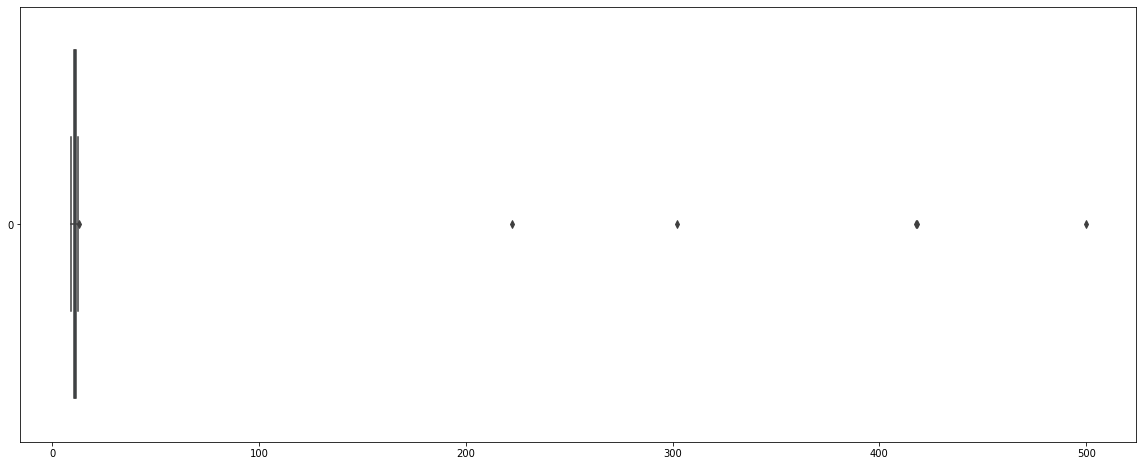

In [38]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Price'], orient="h")

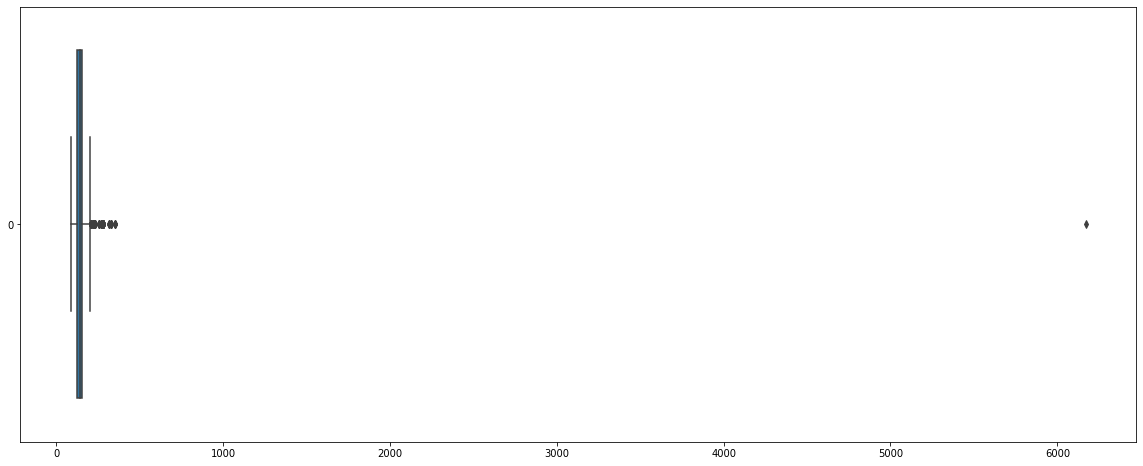

In [39]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Ppi'], orient="h")

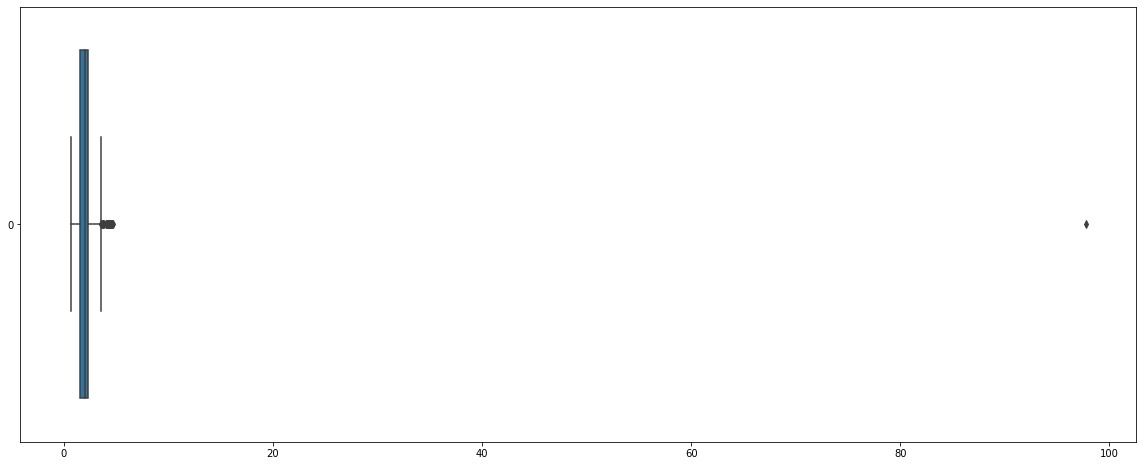

In [40]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Weight'], orient="h")

In [41]:
df=df[(df.Price < 13) & (df.Ppi < 2000) & (df.Weight < 50)]

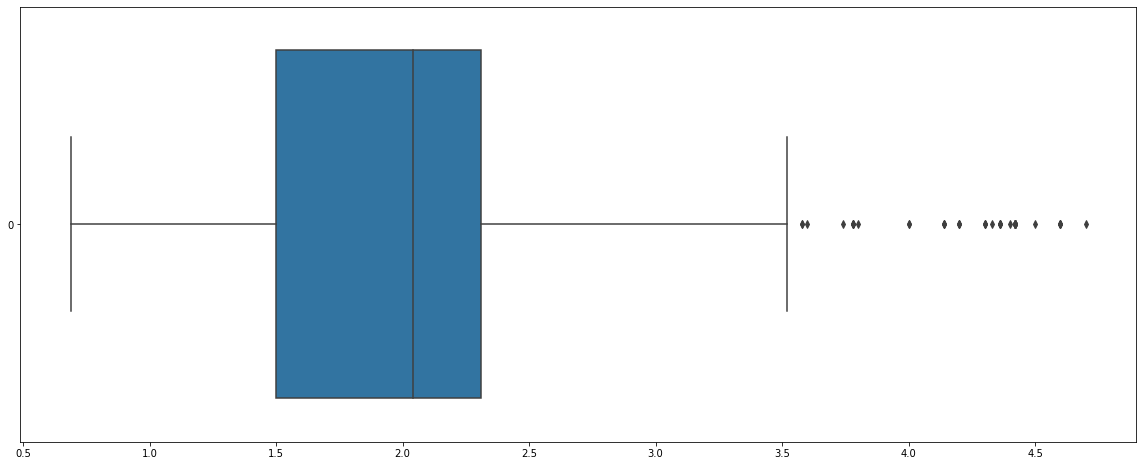

In [87]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Weight'], orient="h")

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.3, random_state=1)

In [43]:
regression= LinearRegression()  

In [44]:
regression.fit(X_train, y_train)

LinearRegression()

In [45]:
pd.DataFrame({'features': features, 'coef': regression.coef_})  

,features,coef
0,Ram,0.048404
1,Weight,0.060715
2,SSD,0.000980
3,TouchScreen,-0.022572
4,Ips,0.112529
5,HDD,0.000035
6,Ppi,0.003195


In [46]:
regression.intercept_

9.606617657790936

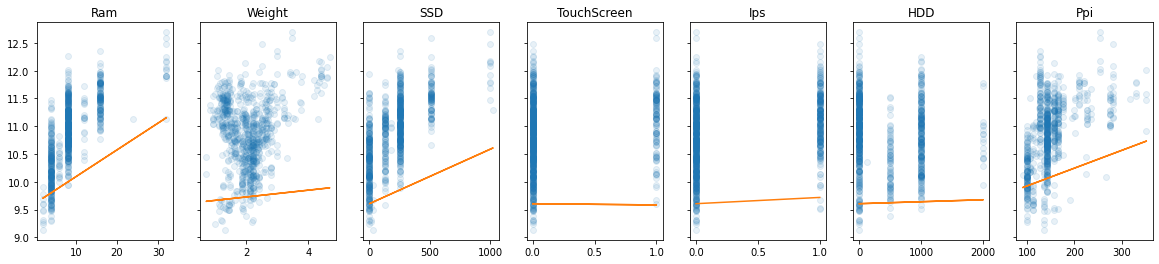

In [47]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

In [48]:
print("MSA")
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))
print("RMSE")
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

MSA
Train: 0.31315675824688743
Test: 0.3085563403364242
RMSE
Train: 0.39049869812634547
Test: 0.3869609240871415


## 6. Entrenamiento de un segundo modelo aplicando normalización

In [49]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.3, random_state=1)

In [51]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [52]:
pd.DataFrame({'features': features, 'coef': pipeline['model'].coef_})

,features,coef
0,Ram,0.245168
1,Weight,0.041045
2,SSD,0.183090
3,TouchScreen,-0.008111
4,Ips,0.051121
5,HDD,0.017837
6,Ppi,0.140867


In [53]:
pipeline['model'].intercept_

10.843754471504695

In [54]:
y_train.mean(), y_test.mean()

(10.843754471504695, 10.823711998106853)

In [55]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


MAE:
Train: 0.3131567582468873
Test: 0.3085563403364234

RMSE:
Train: 0.39049869812634547
Test: 0.38696092408714156


### 6.2 Tercer modelo retirando outliner

In [56]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

12.590330802672073

In [57]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [58]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [59]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [60]:
pd.DataFrame({'features': features, 'coef': pipeline['model'].coef_})

,features,coef
0,Ram,0.243274
1,Weight,0.042462
2,SSD,0.182352
3,TouchScreen,-0.006978
4,Ips,0.049778
5,HDD,0.017399
6,Ppi,0.141053


In [61]:
pipeline['model'].intercept_

10.841481794189782

In [62]:
y_train.mean(), y_test.mean()

(10.841481794189782, 10.823711998106853)

In [63]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


MAE:
Train: 0.312962076531091
Test: 0.30817701971640105

RMSE:
Train: 0.39040935893807266
Test: 0.3868107608284173


### 7.1. Colinealidad

<Axes: >

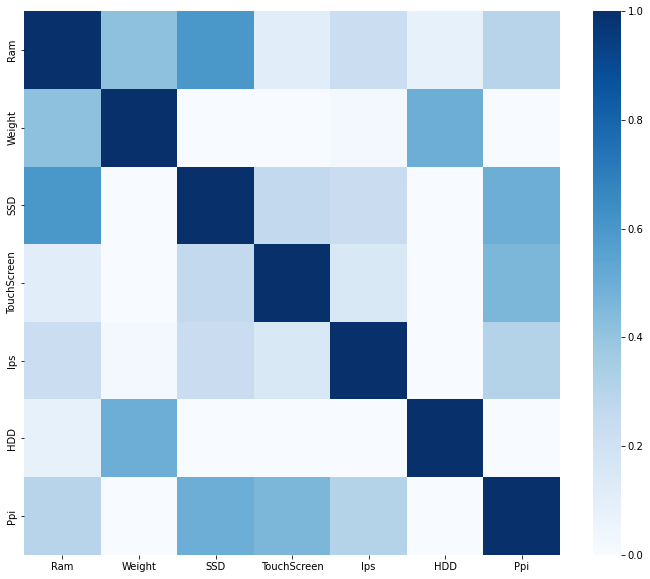

In [64]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [65]:
df[features].corr()

,Ram,Weight,SSD,TouchScreen,Ips,HDD,Ppi
Ram,1.000000,0.401344,0.597973,0.108652,0.217978,0.088136,0.295715
Weight,0.401344,1.000000,-0.045188,-0.280058,0.030378,0.509990,-0.313192
SSD,0.597973,-0.045188,1.000000,0.243592,0.218692,-0.400464,0.501862
TouchScreen,0.108652,-0.280058,0.243592,1.000000,0.128434,-0.197693,0.442048
Ips,0.217978,0.030378,0.218692,0.128434,1.000000,-0.093149,0.293570
HDD,0.088136,0.509990,-0.400464,-0.197693,-0.093149,1.000000,-0.297652
Ppi,0.295715,-0.313192,0.501862,0.442048,0.293570,-0.297652,1.000000


In [66]:
features2=['Ram','SSD','TouchScreen']

In [67]:
df.Ram.describe()

count    1163.000000
mean        8.526225
std         5.150234
min         2.000000
25%         4.000000
50%         8.000000
75%         8.000000
max        64.000000
Name: Ram, dtype: float64

In [68]:
df.SSD.describe()

count    1163.000000
mean      187.594153
std       186.979912
min         0.000000
25%         0.000000
50%       256.000000
75%       256.000000
max      1024.000000
Name: SSD, dtype: float64

In [69]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [70]:
pd.DataFrame({'columns': features2, 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,0.290647
1,SSD,0.216346
2,TouchScreen,0.034544


In [71]:
pipeline['model'].intercept_

10.841481794189782

In [72]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.330454730638564
Test: 0.32163639421136336

RMSE:
Train: 0.4101244617674925
Test: 0.4092497140901838


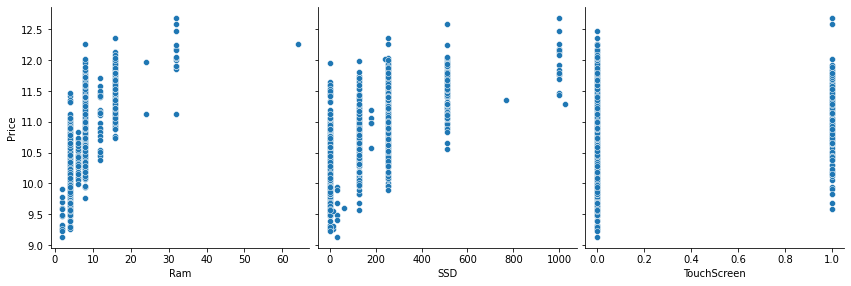

In [73]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features2, kind = 'scatter')

In [74]:
pipeline = Pipeline(
    [
        ('poly', PolynomialFeatures(degree = 2, include_bias = False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [75]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [76]:
pd.DataFrame({'columns': pipeline['poly'].get_feature_names_out(), 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,6.965167e-01
1,SSD,3.536498e-01
2,TouchScreen,3.904768e+12
3,Ram^2,-3.292462e-01
4,Ram SSD,-1.064186e-01
5,Ram TouchScreen,-1.522862e-01
6,SSD^2,-1.324325e-01
7,SSD TouchScreen,6.008522e-02
8,TouchScreen^2,-3.904768e+12


In [77]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.29185722665087166
Test: 0.28852589461026684

RMSE:
Train: 0.36511079153988407
Test: 0.4074740565485277


### 7.3. Normalidad de los errores

In [78]:
errors =(pipeline.predict(X_train[features2]) - y_train).values

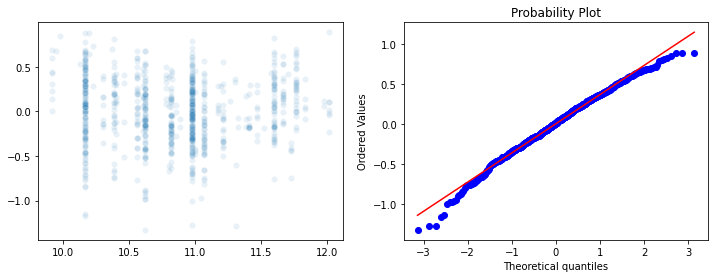

In [79]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train[features2]), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])

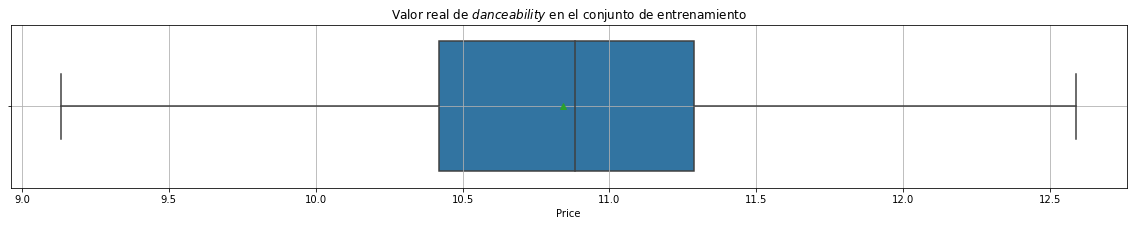

In [80]:
plt.figure(figsize = (20, 3))
sns.boxplot(x = y_train, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{danceability}$ en el conjunto de entrenamiento')
plt.grid()
plt.show()

Valores atípicos

In [81]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

12.589079551374383

In [82]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [83]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [84]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [85]:
pd.DataFrame({'columns': pipeline['poly'].get_feature_names_out(), 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,6.965167e-01
1,SSD,3.536498e-01
2,TouchScreen,3.904768e+12
3,Ram^2,-3.292462e-01
4,Ram SSD,-1.064186e-01
5,Ram TouchScreen,-1.522862e-01
6,SSD^2,-1.324325e-01
7,SSD TouchScreen,6.008522e-02
8,TouchScreen^2,-3.904768e+12


In [86]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.29185722665087166
Test: 0.28852589461026684

RMSE:
Train: 0.36511079153988407
Test: 0.4074740565485277
